In [1]:
import os
import cv2
import glob
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
# !pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif 
# import gif_your_nifti.core as gif2nif


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
from sklearn.metrics import log_loss
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression as MIR
import tensorflow as tf
# from tensorflow.keras.models import *
# from tensorflow.keras.layers import *
# from tensorflow.keras.optimizers import *
# from tensorflow.keras.utils import plot_model, to_categorical   
# from tensorflow.keras.layers.experimental import preprocessing
# from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)


2024-01-15 19:06:19.452467: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/surajit/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2024-01-15 19:06:19.452488: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', 
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# # days start interval
# SURVIVAL_CATEGORIES= {
#     'SHORT' : 0 , # 0-300
#     'MEDIUM' : 250,  # 300-450
#     'LONG' : 450, # 450 and more
# }

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include
IMG_SIZE=128
TRAIN_DATASET_PATH='./MICCAI_BraTS2020_TrainingData/'
VAL_DATASET_PATH='./MICCAI_BraTS2020_ValidationData/'

In [3]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
train_and_val_directories+= [f.path for f in os.scandir(VAL_DATASET_PATH) if f.is_dir()]
# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories)

In [4]:
print(train_and_val_directories)

['./MICCAI_BraTS2020_TrainingData/BraTS20_Training_168', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_051', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_036', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_322', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_327', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_049', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_270', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_109', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_228', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_297', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_069', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_095', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_363', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_234', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_369', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_082', './MICCAI_BraTS2020_TrainingData/BraTS20_Training_204', './MICCAI_BraTS2020_TrainingData/BraTS20_Traini

In [9]:
import csv

csvs = [r'MICCAI_BraTS2020_TrainingData/survival_info.csv', r'MICCAI_BraTS2020_ValidationData/survival_evaluation.csv']

age_dict = {}
days_dict = {}
at_line = 0
category_short = 0
category_medium = 0
category_long = 0
max_days = 0
for csv_path in csvs:
    with open(csv_path, mode='r') as csv_file:
        csv_reader = csv.reader(csv_file,delimiter = ',')
    #  row_count = sum(1 for row in csv_reader)
    #   print(f'total rows: {row_count} .')
        for row in csv_reader:
            if at_line == 0:
                # print(f'Column names are {", ".join(row)}')
                at_line += 1
            else:
                if (row[-1] != "GTR"):
                    continue
                # print(row)
                key = row[0]
                age = row[1]
                days = row[2]
                age_dict[key] = float(age)
                if (not days.isnumeric()):
                    continue
                days_dict[key] = int(days)
                max_days = max(max_days,int(days))
                if int(days) < 250:
                    category_short += 1
                elif (int(days) >= 250 and int(days) <= 450):
                    category_medium += 1
                else:
                    category_long += 1
                at_line+=1

    print(f'Processed {at_line} lines.')
    print(category_short,category_medium,category_long)
    print(max_days)

Processed 119 lines.
34 38 46
1767
Processed 119 lines.
34 38 46
1767


In [12]:
import csv

def col_and_eval(ch_ft = []):
    id_list2 = []
    csv_filenames = [r'./results.csv',r'./results_val.csv']
    dt =[]
    jj = [] #key_list
    id_tp = 0
    row_cc = 0
    row2 = {}
    id_check = {}
    for csv_filename in csv_filenames:
        with open(csv_filename) as f:
            reader = csv.DictReader(f)
            for row in reader:
                # if row_cc > 20:
                #     break
                # row_cc += 1
                dt_tp = row
                if row['Patient_ID'] not in id_check:
                    id_check[row['Patient_ID']] = 0
                id_check[row['Patient_ID']] += 1
                if len(id_list2) != 0:
                    if id_list2[-1] == row["Patient_ID"]:
                        id_tp += 1
                    else:
                        dt.append(row2)
                        row2 = {}
                        id_tp = 0
                if id_tp == 0:
                    id_list2.append(row["Patient_ID"])
                if len(id_list2) == 1:
                    for keysj in row:
                        if keysj != None:
                            if 'diagnostic' in keysj or 'Modality' in keysj or 'Patient_ID' in keysj:
                                continue
                            # print(type(keysj),keysj, type(row[keysj]),row[keysj])
                            row[keysj] = eval(row[keysj])
                            if isinstance(row[keysj],tuple):
                                ct = 0
                                for it in row[keysj]:
                                    keysjn = keysj + str(ct)
                                    keysjn += row["Modality"][row["Modality"].find('_',19,-1):row["Modality"].find('.')]
                                    if (keysjn in ch_ft) or (len(ch_ft) == 0):
                                        jj.append(keysjn)
                                    ct += 1
                                continue
                            keysj += row["Modality"][row["Modality"].find('_',19,-1):row["Modality"].find('.')]
                            if (keysj in ch_ft) or (len(ch_ft) == 0):
                                jj.append(keysj)
                for keysj in row:
                    if keysj != None:
                        if 'diagnostic' in keysj or 'Modality' in keysj or 'Patient_ID' in keysj:
                            continue
                        # print(type(keysj),keysj, type(row[keysj]),row[keysj])
                        row[keysj] = eval(str(row[keysj]))
                        keys2j = keysj + row["Modality"][row["Modality"].find('_',19,-1):row["Modality"].find('.')]
                        if isinstance(row[keysj],tuple):
                            ct = 0
                            for it in row[keysj]:
                                keys2j =  keysj + str(ct) + row["Modality"][row["Modality"].find('_',19,-1):row["Modality"].find('.')]
                                row2[keys2j] = it
                                ct += 1
                            continue
                        row2[keys2j] = row[keysj]
                row2['Patient_ID'] = row['Patient_ID']
    dt.append(row2)    
    return dt, jj

# print(jj)
# print(dt)
# create only age: category data


In [13]:
# id: age, categories
def getListAgeDays(id_list, dt, jj, ch_ft = []):
    x_val = []
    y_val = []
    x_test = []
    for i in dt:
        if ((i["Patient_ID"] not in days_dict) and ("Validation" not in i["Patient_ID"])):
            # print(i["Patient_ID"])
            continue
        # if (i not in id_list2):
        #     continue
        # masks = getMaskSizesForVolume(nib.load(TRAIN_DATASET_PATH + f'BraTS20_Training_{i[-3:]}/BraTS20_Training_{i[-3:]}_seg.nii.gz').get_fdata())
        # brain_vol = getBrainSizeForVolume(nib.load(TRAIN_DATASET_PATH + f'BraTS20_Training_{i[-3:]}/BraTS20_Training_{i[-3:]}_t1.nii.gz').get_fdata())
        # masks[1] = masks[1]/brain_vol
        # masks[2] = masks[2]/brain_vol
        # masks[3] = masks[3]/brain_vol
        # merged=[age_dict[i],masks[1],masks[2],masks[3]] ## add segments
        # ft = dt[]
        if (i["Patient_ID"] not in age_dict):
            continue
        j = [age_dict[i["Patient_ID"]]]
        for keysj in i:
            if keysj != None:
                if 'diagnostic' in keysj or 'Modality' in keysj or 'Patient_ID' in keysj:
                    continue
                if (keysj not in ch_ft) and (len(ch_ft) != 0):
                    continue
                # if(i[keysj][0]=='('):
                #     i[keysj] = tuple(i[keysj])
                # else:
                # print(i[keysj])
                # i[keysj] = eval(i[keysj])
                # if isinstance(i[keysj],tuple):
                #     ct = 0
                #     for it in i[keysj]:
                #         keysjn = keysj + str(ct)
                #         j.append(it)
                #         ct += 1
                #     continue
                j.append(i[keysj])
        # print(j)
        if "Validation" in i["Patient_ID"]:
            # print("vvv"+i["Patient_ID"])
            x_test.append(j)
        else:
            x_val.append(j) 
            y_val.append(days_dict[i["Patient_ID"]])
        # if (days_dict[i["Patient_ID"]] < 250):
        #     y_val.append(0)
        # elif (days_dict[i["Patient_ID"]] >= 250 and days_dict[i["Patient_ID"]] < 450):
        #     y_val.append(1)
        # else:
        #     y_val.append(2)
            
    return np.array(x_val), np.array(y_val), np.array(x_test)

dt, jj = col_and_eval()
X_all, y_all, x_val = getListAgeDays(train_and_test_ids,dt,jj)
print(len(train_and_test_ids))
print(X_all.shape)
print(y_all.shape)
print(x_val.shape)
print(f'X_all: {X_all.shape}')
columns = ["age"]+jj+["prediction"]
print(columns)
dfn = np.concatenate((X_all, y_all[:,None]), axis=1)
print(dfn.shape,len(columns))
df = pd.DataFrame(dfn, columns = columns)
df2 = pd.DataFrame(x_val,columns = ["age"]+jj)
df2.head()

493
(117, 10701)
(117,)
(28, 10701)
X_all: (117, 10701)
['age', 'original_shape_Elongation_flair', 'original_shape_Flatness_flair', 'original_shape_LeastAxisLength_flair', 'original_shape_MajorAxisLength_flair', 'original_shape_Maximum2DDiameterColumn_flair', 'original_shape_Maximum2DDiameterRow_flair', 'original_shape_Maximum2DDiameterSlice_flair', 'original_shape_Maximum3DDiameter_flair', 'original_shape_MeshVolume_flair', 'original_shape_MinorAxisLength_flair', 'original_shape_Sphericity_flair', 'original_shape_SurfaceArea_flair', 'original_shape_SurfaceVolumeRatio_flair', 'original_shape_VoxelVolume_flair', 'original_firstorder_10Percentile_flair', 'original_firstorder_90Percentile_flair', 'original_firstorder_Energy_flair', 'original_firstorder_Entropy_flair', 'original_firstorder_InterquartileRange_flair', 'original_firstorder_Kurtosis_flair', 'original_firstorder_Maximum_flair', 'original_firstorder_MeanAbsoluteDeviation_flair', 'original_firstorder_Mean_flair', 'original_firsto

,age,original_shape_Elongation_flair,original_shape_Flatness_flair,original_shape_LeastAxisLength_flair,original_shape_MajorAxisLength_flair,original_shape_Maximum2DDiameterColumn_flair,original_shape_Maximum2DDiameterRow_flair,original_shape_Maximum2DDiameterSlice_flair,original_shape_Maximum3DDiameter_flair,original_shape_MeshVolume_flair,...,getLBP2DImage_0_original_glszm_SmallAreaHighGrayLevelEmphasis_t2,getLBP2DImage_0_original_glszm_SmallAreaLowGrayLevelEmphasis_t2,getLBP2DImage_0_original_glszm_ZoneEntropy_t2,getLBP2DImage_0_original_glszm_ZonePercentage_t2,getLBP2DImage_0_original_glszm_ZoneVariance_t2,getLBP2DImage_0_original_ngtdm_Busyness_t2,getLBP2DImage_0_original_ngtdm_Coarseness_t2,getLBP2DImage_0_original_ngtdm_Complexity_t2,getLBP2DImage_0_original_ngtdm_Contrast_t2,getLBP2DImage_0_original_ngtdm_Strength_t2
0,68.170,0.708109,0.549494,44.532841,81.043346,77.491935,89.944427,82.540899,91.181138,90802.87500,...,1.388889e-02,1.388889e-02,1.000000e+00,0.000022,2.063521e+09,0.0,1000000.0,0.0,0.0,0.0
1,50.153,0.713522,0.581695,28.423128,48.862599,48.662100,50.606324,42.011903,51.662365,19210.95833,...,2.700000e-09,2.700000e-09,-3.200000e-16,0.000052,0.000000e+00,0.0,1000000.0,0.0,0.0,0.0
2,21.726,0.572874,0.488275,47.082522,96.426173,70.830784,110.367568,99.609237,110.742946,59501.04167,...,2.812822e-02,2.812822e-02,2.000000e+00,0.000067,6.654277e+08,0.0,1000000.0,0.0,0.0,0.0
3,55.482,0.647488,0.498546,45.320963,90.906282,70.576200,94.339811,94.085068,94.620294,99705.66667,...,1.676474e-01,1.676474e-01,2.584963e+00,0.000060,1.381898e+09,0.0,1000000.0,0.0,0.0,0.0
4,64.753,0.729476,0.516040,43.413481,84.128141,80.000000,84.403791,80.056230,87.464278,57203.79167,...,1.718748e-01,1.718748e-01,2.405639e+00,0.000140,3.572158e+08,0.0,1000000.0,0.0,0.0,0.0


In [14]:
scaler = MinMaxScaler()
v = X_all
v_scaled = scaler.fit_transform(v)
X_all = v_scaled
X_val = scaler.fit_transform(x_val)

df = pd.DataFrame(X_all, columns = ["age"]+jj)
# display(df)
df2 = pd.DataFrame(X_val,columns = ["age"]+jj)
df2.head()

,age,original_shape_Elongation_flair,original_shape_Flatness_flair,original_shape_LeastAxisLength_flair,original_shape_MajorAxisLength_flair,original_shape_Maximum2DDiameterColumn_flair,original_shape_Maximum2DDiameterRow_flair,original_shape_Maximum2DDiameterSlice_flair,original_shape_Maximum3DDiameter_flair,original_shape_MeshVolume_flair,...,getLBP2DImage_0_original_glszm_SmallAreaHighGrayLevelEmphasis_t2,getLBP2DImage_0_original_glszm_SmallAreaLowGrayLevelEmphasis_t2,getLBP2DImage_0_original_glszm_ZoneEntropy_t2,getLBP2DImage_0_original_glszm_ZonePercentage_t2,getLBP2DImage_0_original_glszm_ZoneVariance_t2,getLBP2DImage_0_original_ngtdm_Busyness_t2,getLBP2DImage_0_original_ngtdm_Coarseness_t2,getLBP2DImage_0_original_ngtdm_Complexity_t2,getLBP2DImage_0_original_ngtdm_Contrast_t2,getLBP2DImage_0_original_ngtdm_Strength_t2
0,0.726244,0.414664,0.554768,0.618613,0.703363,0.864464,0.717478,0.746378,0.730597,0.678942,...,2.777778e-02,2.777778e-02,0.356207,0.007783,0.804518,0.0,0.0,0.0,0.0,0.0
1,0.444512,0.427461,0.639311,0.213227,0.207936,0.257954,0.173298,0.144148,0.186348,0.103571,...,5.283200e-09,5.283200e-09,0.000000,0.024042,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.094908,0.394040,0.682773,0.940184,0.724329,1.000000,1.000000,1.000000,0.427375,...,5.625643e-02,5.625643e-02,0.712414,0.032172,0.259434,0.0,0.0,0.0,0.0,0.0
3,0.527842,0.271328,0.421005,0.638445,0.855204,0.718974,0.778281,0.917915,0.777960,0.750492,...,3.352948e-01,3.352948e-01,0.920782,0.028378,0.538769,0.0,0.0,0.0,0.0,0.0
4,0.672812,0.465184,0.466935,0.590445,0.750854,0.917228,0.640832,0.709457,0.679408,0.408912,...,3.437496e-01,3.437496e-01,0.856906,0.071481,0.139270,0.0,0.0,0.0,0.0,0.0


In [15]:
# X_train, X_test, y_train, y_test = train_test_split(X_all,y_all,test_size = 0.2, random_state = 42, shuffle = True)
X_train = X_all
y_train = y_all
print("x_train shape:",X_train.shape)
# print("x_test shape:", X_test.shape)
print("y_train shape:",y_train.shape)
# print("y_test shape:", y_test.shape)

x_train shape: (117, 10701)
y_train shape: (117,)


In [18]:
from skfeature.function.similarity_based import fisher_score

print(X_train.shape,y_train.shape)
_ranks = fisher_score.fisher_score(X_train,y_train)

(117, 10701) (117,)


/home/surajit/anaconda3/lib/python3.9/site-packages/skfeature/function/similarity_based/fisher_score.py:59: RuntimeWarning: divide by zero encountered in true_divide
  score = 1.0 / lap_score - 1


In [19]:
# ft_sc = {}
# ii = 0
# columns = ["age"]+jj
# for it in columns[:-1]:
#     ft_sc[it] = _ranks[ii]
#     ii += 1

# sorted_ft_sc = sorted(ft_sc.items(), key=lambda x:x[1], reverse=True)
# sorted_ft_sc = dict(sorted_ft_sc)
# print(sorted_ft_sc)
# print(_ranks)
# print(columns[_ranks[0]])

In [20]:
# ij = 0
# chosen_ft = {}
# for it in sorted_ft_sc:
#     chosen_ft[it] = sorted_ft_sc[it]
#     ij += 1
#     if ij>=400:
#         break

# print(chosen_ft)

In [21]:
columns = ["age"]+jj
colnew = []
def prune2(X):
    xx = []
    for row in X:
        iter = 0
        xxtp = []
        for col in row:
            if _ranks[iter]<400:
                xxtp.append(col)
                if columns[iter] not in colnew:
                    colnew.append(columns[iter])
            iter += 1
        xx.append(xxtp)
    return xx

x_train = np.array(prune2(X_train))
x_test = np.array(prune2(X_val))

print(x_train.shape)
print(x_test.shape)
df = pd.DataFrame(x_train, columns = colnew)
df2 = pd.DataFrame(x_test,columns = colnew)
# df2.head()
df.head()

(117, 400)
(28, 400)


,original_shape_Elongation_flair,original_shape_Maximum3DDiameter_flair,original_glcm_ClusterShade_flair,original_gldm_SmallDependenceEmphasis_flair,getLoGImage_5.0_original_firstorder_Maximum_flair,getLoGImage_5.0_original_firstorder_MeanAbsoluteDeviation_flair,getLoGImage_5.0_original_gldm_GrayLevelNonUniformity_flair,getLoGImage_5.0_original_gldm_LargeDependenceLowGrayLevelEmphasis_flair,getLoGImage_5.0_original_glrlm_HighGrayLevelRunEmphasis_flair,getLoGImage_5.0_original_glrlm_ShortRunEmphasis_flair,...,getLBP2DImage_0_original_shape_MinorAxisLength_t2,getLBP2DImage_0_original_shape_Sphericity_t2,getLBP2DImage_0_original_shape_SurfaceArea_t2,getLBP2DImage_0_original_shape_SurfaceVolumeRatio_t2,getLBP2DImage_0_original_shape_VoxelVolume_t2,getLBP2DImage_0_original_firstorder_10Percentile_t2,getLBP2DImage_0_original_firstorder_90Percentile_t2,getLBP2DImage_0_original_firstorder_Energy_t2,getLBP2DImage_0_original_firstorder_Entropy_t2,getLBP2DImage_0_original_firstorder_Kurtosis_t2
0,0.656126,0.416847,0.815173,0.050751,0.345106,0.116403,0.191465,0.112951,0.046658,0.206108,...,0.717712,0.289313,0.386828,0.102585,0.280596,0.5,1.0,0.321960,0.0,0.134921
1,0.756109,0.174373,0.829778,0.155459,0.543474,0.442939,0.044984,0.011372,0.227396,0.696845,...,0.398569,1.000000,0.119833,0.030538,0.165796,0.5,1.0,0.199098,0.0,0.063408
2,0.705924,0.060153,0.814258,0.089222,0.209580,0.167279,0.007795,0.217731,0.023335,0.541804,...,0.099359,0.419048,0.033119,0.309301,0.011822,0.5,1.0,0.013946,0.0,0.074459
3,0.858806,0.271989,0.817671,0.136910,0.428894,0.218452,0.091877,0.033670,0.082501,0.527134,...,0.651013,0.132165,0.412923,0.186171,0.197625,0.5,1.0,0.222107,0.0,0.114481
4,0.125925,0.396104,0.806434,0.269195,0.194903,0.129068,0.044958,0.328433,0.019532,0.635800,...,0.349422,0.051572,0.224231,0.384664,0.064645,0.5,1.0,0.068392,0.0,0.116146


In [22]:
# dt, jj = col_and_eval(chosen_ft)

In [23]:
# ch_X_all, ch_y_all, ch_x_test = getListAgeDays(train_and_test_ids,dt,jj,ch_ft=chosen_ft)
# print(len(train_and_test_ids))
# print(ch_X_all.shape)
# print(ch_x_test.shape)
# print(ch_y_all.shape)
# columns = ["age"]+jj+["prediction"]
# print(columns)
# ch_dfn = np.concatenate((ch_X_all, ch_y_all[:,None]), axis=1)
# print(ch_dfn.shape,len(columns))
# df = pd.DataFrame(ch_dfn, columns = columns)
# df2 = pd.DataFrame(ch_x_test,columns = ["age"]+jj)
# df2.head()
# df.head()

In [24]:
scaler = MinMaxScaler()
v = x_train
v_scaled = scaler.fit_transform(v)
x_train = v_scaled
v = x_test
v_scaled = scaler.fit_transform(v)
x_test = v_scaled

df = pd.DataFrame(x_train, columns = colnew)
display(df)

,original_shape_Elongation_flair,original_shape_Maximum3DDiameter_flair,original_glcm_ClusterShade_flair,original_gldm_SmallDependenceEmphasis_flair,getLoGImage_5.0_original_firstorder_Maximum_flair,getLoGImage_5.0_original_firstorder_MeanAbsoluteDeviation_flair,getLoGImage_5.0_original_gldm_GrayLevelNonUniformity_flair,getLoGImage_5.0_original_gldm_LargeDependenceLowGrayLevelEmphasis_flair,getLoGImage_5.0_original_glrlm_HighGrayLevelRunEmphasis_flair,getLoGImage_5.0_original_glrlm_ShortRunEmphasis_flair,...,getLBP2DImage_0_original_shape_MinorAxisLength_t2,getLBP2DImage_0_original_shape_Sphericity_t2,getLBP2DImage_0_original_shape_SurfaceArea_t2,getLBP2DImage_0_original_shape_SurfaceVolumeRatio_t2,getLBP2DImage_0_original_shape_VoxelVolume_t2,getLBP2DImage_0_original_firstorder_10Percentile_t2,getLBP2DImage_0_original_firstorder_90Percentile_t2,getLBP2DImage_0_original_firstorder_Energy_t2,getLBP2DImage_0_original_firstorder_Entropy_t2,getLBP2DImage_0_original_firstorder_Kurtosis_t2
0,0.656126,0.416847,0.815173,0.050751,0.345106,0.116403,0.191465,0.112951,0.046658,0.206108,...,0.717712,0.289313,0.386828,0.102585,0.280596,0.5,1.00,0.321960,0.0,0.134921
1,0.756109,0.174373,0.829778,0.155459,0.543474,0.442939,0.044984,0.011372,0.227396,0.696845,...,0.398569,1.000000,0.119833,0.030538,0.165796,0.5,1.00,0.199098,0.0,0.063408
2,0.705924,0.060153,0.814258,0.089222,0.209580,0.167279,0.007795,0.217731,0.023335,0.541804,...,0.099359,0.419048,0.033119,0.309301,0.011822,0.5,1.00,0.013946,0.0,0.074459
3,0.858806,0.271989,0.817671,0.136910,0.428894,0.218452,0.091877,0.033670,0.082501,0.527134,...,0.651013,0.132165,0.412923,0.186171,0.197625,0.5,1.00,0.222107,0.0,0.114481
4,0.125925,0.396104,0.806434,0.269195,0.194903,0.129068,0.044958,0.328433,0.019532,0.635800,...,0.349422,0.051572,0.224231,0.384664,0.064645,0.5,1.00,0.068392,0.0,0.116146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,0.522913,0.281444,0.814210,0.005661,0.241904,0.000000,0.344601,0.140379,0.042005,0.000000,...,0.488836,0.476993,0.257988,0.072479,0.231555,0.5,1.00,0.268073,0.0,0.110025
113,0.492875,0.392684,0.802848,0.020952,0.318705,0.141052,0.277558,0.093331,0.062563,0.174523,...,0.599050,0.500579,0.383955,0.045440,0.434880,0.5,0.75,0.436602,0.0,0.296937
114,0.430218,0.330815,0.815283,0.009775,0.323282,0.057158,0.067648,0.204677,0.016764,0.200776,...,0.254618,0.707799,0.084903,0.091646,0.069980,0.5,0.50,0.061314,0.0,0.422460
115,0.380998,0.252184,0.860577,0.446064,0.467367,1.000000,0.004014,0.002010,0.586474,0.868604,...,0.306783,0.301750,0.064500,0.301888,0.022748,0.5,0.75,0.022454,0.0,0.322749


In [25]:
# X_train, X_test, y_train, y_test = train_test_split(X_all,y_all,test_size = 0.2, random_state = 42, shuffle = True)
# x_train = ch_X_all
# y_train = ch_y_all
# x_test = ch_x_test
print("x_train shape:",x_train.shape)
# print("x_test shape:", X_test.shape)
print("y_train shape:",y_train.shape)
# print("y_test shape:", y_test.shape)

x_train shape: (117, 400)
y_train shape: (117,)


**# mrmr implementation**

In [26]:
def rank(X,y,nbSolutions,I_xy):
    f_mir = []
    for i in range(int(X.shape[1])):
        f_mir.append([I_xy[i],i])
    f_mir.sort(reverse=True)
    S=[]
    si = []
    for i in range(nbSolutions):
        si.append(f_mir[i][1])
        S.append(si)
        si = []
    return S

In [27]:
def score(f,X,y,Si,I_xy,I_xx):
    if f == -1:
        return float("-INF")
    mi_temp = 0
    qj = I_xy[f]
    for xi in Si:
        mi_temp += I_xx[xi][f]
    mi_temp/=len(Si)
    qj += mi_temp
    return qj

In [28]:
#Mutual Implementation

I_xx = np.zeros((x_train.shape[1],x_train.shape[1]))
I_xy = np.zeros(x_train.shape[1])
print(I_xx.shape,I_xy.shape)

i1=0
for f1 in x_train.T:
    # print(res)
    # I_xx[i1][i2] = (-0.5)*math.log(1-(res*res))
    I_xx[i1] = MIR(x_train,list(f1))
    i1 += 1
    print(f"Processed MI with {i1} features so far...")

#each iteration taking ~30s and 10702 such iterations. thus, IMPOSSIBLE

(400, 400) (400,)
Processed MI with 1 features so far...
Processed MI with 2 features so far...
Processed MI with 3 features so far...
Processed MI with 4 features so far...
Processed MI with 5 features so far...
Processed MI with 6 features so far...
Processed MI with 7 features so far...
Processed MI with 8 features so far...
Processed MI with 9 features so far...
Processed MI with 10 features so far...
Processed MI with 11 features so far...
Processed MI with 12 features so far...
Processed MI with 13 features so far...
Processed MI with 14 features so far...
Processed MI with 15 features so far...
Processed MI with 16 features so far...
Processed MI with 17 features so far...
Processed MI with 18 features so far...
Processed MI with 19 features so far...
Processed MI with 20 features so far...
Processed MI with 21 features so far...
Processed MI with 22 features so far...
Processed MI with 23 features so far...
Processed MI with 24 features so far...
Processed MI with 25 features s

Processed MI with 204 features so far...
Processed MI with 205 features so far...
Processed MI with 206 features so far...
Processed MI with 207 features so far...
Processed MI with 208 features so far...
Processed MI with 209 features so far...
Processed MI with 210 features so far...
Processed MI with 211 features so far...
Processed MI with 212 features so far...
Processed MI with 213 features so far...
Processed MI with 214 features so far...
Processed MI with 215 features so far...
Processed MI with 216 features so far...
Processed MI with 217 features so far...
Processed MI with 218 features so far...
Processed MI with 219 features so far...
Processed MI with 220 features so far...
Processed MI with 221 features so far...
Processed MI with 222 features so far...
Processed MI with 223 features so far...
Processed MI with 224 features so far...
Processed MI with 225 features so far...
Processed MI with 226 features so far...
Processed MI with 227 features so far...
Processed MI wit

In [29]:
I_xy = MIR(x_train,list(y_train))

In [30]:
S= rank(x_train,y_train,10,I_xy)

lenSol = 25
nbSol = 10
l = 1

while l<lenSol:
    i = 0
    # print(S)
    while i< nbSol:
        c = -1
        for f in range(int(x_train.shape[1])):
            if f in S[i]:
                continue
            if score(f,x_train,y_train,S[i],I_xy,I_xx)>=score(c,x_train,y_train,S[i],I_xy,I_xx):
                flag = 1
                for j in range(nbSol):
                    if j==i:
                        continue
                    if f not in S[j]:
                        flag = 0
                    for k in S[i]:
                        if k not in S[j]:
                            flag = 0
                if flag:
                    continue
                c = f
        S[i].append(c)
        i += 1
    l += 1
print(len(S),len(S[0]))


10 25


In [31]:
def prune(X,Si):
    xx = []
    for row in X:
        iter = 0
        xxtp = []
        for col in row:
            if iter in Si:
                xxtp.append(col)
            iter += 1
        xx.append(xxtp)
    return xx

In [32]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [33]:
from sklearn.metrics import mean_squared_error
import statistics
from scipy import stats

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    print(predictions)
    med_arr = [(yt-yp)*(yt-yp) for yt,yp in zip(predictions,test_labels)]
    return mean_squared_error(test_labels,predictions),statistics.median(med_arr),statistics.stdev(med_arr),stats.spearmanr(test_labels,predictions),predictions


In [34]:
def classif(y_train,y_pred):  
    y_train_v = []
    y_pred_v = []
    for yi in y_train:
        if (yi < 300):
            y_train_v.append(0)
        elif (yi >= 300 and yi < 450):
            y_train_v.append(1)
        else:
            y_train_v.append(2)

    for yi in y_pred:
        if (yi < 300):
            y_pred_v.append(0)
        elif (yi >= 300 and yi < 450):
            y_pred_v.append(1)
        else:
            y_pred_v.append(2)
    return y_train_v,y_pred_v

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[334.307 658.758 434.96  588.838 481.979 394.618 564.63  933.231 464.972
 449.288 460.196 435.63  317.656 378.601 409.227 461.269 299.24  537.933
 367.073 404.93  403.95  230.004 524.828 864.04  227.722 284.194 250.497
 701.041 646.731 468.043 511.991 293.159 297.512 311.936 279.167 501.089
 546.229 935.415 386.762 285.032 508.138 591.916 637.907 497.731 257.444
 389.341 964.471 364.324 324.561 391.091 251.467 338.654 420.348 275.896
 394.144 340.494 560.373 398.208 375.758 385.419 734.227 341.296 232.584
 178.375 723.27  340.13  335.738 808.373 322.8   496.166 226.72  455.589
 406.761 467.528 403.784 264.59  535.064 526.22  257.529 374.63  396.71
 305.882 431.207 411.292 493.983 324.453 414.369 550.065 563.162 661.353
 432.144 392.745 561.76  498.703 378.795 425.358 707.585 360.969 620.515
 495.636 642.853 425.552 657.688 247.584 687.441 346.175 641.785 439.445
 495.479 305.469 383.732 494.805 

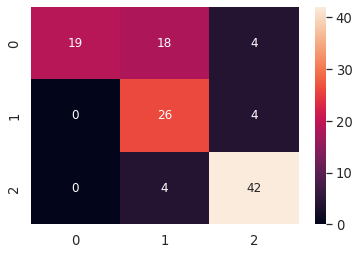

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[ 304.727  531.716  439.979  673.182  479.043  355.991  527.724  860.146
  561.284  443.871  629.413  370.16   369.215  401.393  431.379  488.671
  281.416  506.459  419.692  394.545  370.52   315.937  420.961 1021.416
  215.058  277.509  201.146  610.916  579.597  443.598  554.8    310.457
  325.04   359.319  365.219  357.019  433.761 1210.694  313.717  154.462
  529.659  552.971  399.259  355.181  241.259  384.263 1264.612  243.747
  351.173  248.759  278.498  206.631  371.425  186.319  502.613  408.975
  473.653  403.948  347.083  264.424 1143.707  371.773  179.87   169.087
  894.47   302.324  231.297  904.338  195.028  527.63   253.434  486.393
  432.123  413.203  372.018  173.271  548.003  519.303  277.973  526.509
  419.235  366.815  507.556  331.614  594.59   436.948  382.232  454.84
  600.34  1073.716  454.387  246.532  636.992  222.443  258.861  344.995
  567.997  375.52   639.041  527.

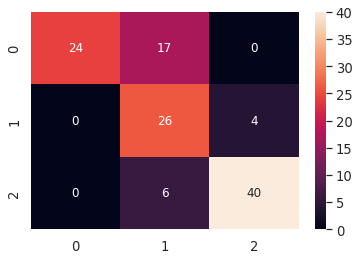

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.497 total time=   1.7s
[CV 2/3] END bootstrap=False, max_depth=80, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=-0.171 total time=   0.3s
[CV 2/3] END bootstrap=False, max_depth=70, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.538 total time=   1.0s
[CV 2/3] END bootstrap=True, max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=1400;, score=0.047 total time=   2.7s
[CV 2/3] END bootstrap=False, max_depth=110, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=-0.566 total time=   0.9s
[CV 3/3] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=-1.641 total time=   1.8s
[CV 3/3] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, 

[CV 2/3] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=2000;, score=-0.251 total time=   4.8s
[CV 3/3] END bootstrap=True, max_depth=80, min_samples_leaf=2, min_samples_split=5, n_estimators=1000;, score=-0.793 total time=   2.0s
[CV 1/3] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=-0.246 total time=   1.7s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=2000;, score=0.108 total time=   3.8s
[CV 3/3] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=1600;, score=-0.730 total time=   2.9s
[CV 1/3] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=400;, score=0.091 total time=   0.8s
[CV 1/3] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=1000;, score=0.090 total time=   2.1s
[CV 1/3] END bootstrap=False, max_depth=70,

[CV 3/3] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-1.293 total time=   1.4s
[CV 3/3] END bootstrap=True, max_depth=90, min_samples_leaf=4, min_samples_split=2, n_estimators=1800;, score=-0.734 total time=   3.1s
[CV 2/3] END bootstrap=True, max_depth=80, min_samples_leaf=2, min_samples_split=5, n_estimators=1000;, score=0.034 total time=   2.1s
[CV 1/3] END bootstrap=True, max_depth=70, min_samples_leaf=1, min_samples_split=10, n_estimators=1600;, score=0.097 total time=   3.1s
[CV 3/3] END bootstrap=False, max_depth=90, min_samples_leaf=2, min_samples_split=5, n_estimators=1200;, score=-1.268 total time=   2.5s
[CV 2/3] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.084 total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.056 total time=   0.4s
[CV 2/3] END bootstrap=True, max_depth=30, min_sa

[CV 2/3] END bootstrap=True, max_depth=80, min_samples_leaf=2, min_samples_split=2, n_estimators=1800;, score=0.029 total time=   2.9s
[CV 3/3] END bootstrap=False, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=1600;, score=-1.329 total time=   3.8s
[CV 2/3] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=-0.163 total time=   1.7s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=2000;, score=0.037 total time=   3.8s
[CV 1/3] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.108 total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.042 total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=400;, score=0.146 total time=   0.7s
[CV 3/3] END bootstrap=False, max_depth=40, min_s

[CV 1/3] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=2000;, score=-0.493 total time=   4.6s
[CV 3/3] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=1600;, score=-1.641 total time=   3.1s
[CV 3/3] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=1200;, score=-0.811 total time=   2.3s
[CV 1/3] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.367 total time=   0.4s
[CV 1/3] END bootstrap=True, max_depth=70, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=0.114 total time=   0.7s
[CV 1/3] END bootstrap=False, max_depth=50, min_samples_leaf=1, min_samples_split=5, n_estimators=1200;, score=-0.312 total time=   2.8s
[CV 2/3] END bootstrap=False, max_depth=40, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=-0.182 total time=   0.3s
[CV 2/3] END bootstrap=False, max_depth

[CV 1/3] END bootstrap=True, max_depth=80, min_samples_leaf=2, min_samples_split=2, n_estimators=1800;, score=0.128 total time=   2.9s
[CV 1/3] END bootstrap=False, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=1600;, score=-0.502 total time=   4.3s
[CV 1/3] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=1200;, score=0.135 total time=   2.3s
[CV 1/3] END bootstrap=False, max_depth=70, min_samples_leaf=1, min_samples_split=10, n_estimators=400;, score=-0.308 total time=   0.9s
[CV 2/3] END bootstrap=True, max_depth=70, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=0.050 total time=   0.7s
[CV 2/3] END bootstrap=False, max_depth=50, min_samples_leaf=1, min_samples_split=5, n_estimators=1200;, score=-0.260 total time=   2.9s
[CV 3/3] END bootstrap=True, max_depth=110, min_samples_leaf=4, min_samples_split=2, n_estimators=1200;, score=-0.726 total time=   2.2s
[CV 2/3] END bootstrap=False, max_depth=80, min

[572.289 548.509 619.237 600.142 453.328 332.896 491.837 641.731 507.002
 453.181 591.665 358.959 255.515 446.623 407.239 539.637 371.666 657.653
 459.423 333.666 334.844 396.39  381.502 633.142 369.177 330.387 272.024
 593.032 538.67  626.443 514.172 375.821 264.654 600.292 262.989 621.41
 498.614 807.79  425.896 206.039 620.912 386.622 587.638 319.436 290.211
 374.883 799.594 339.232 316.166 211.284 348.14  291.184 565.463 267.502
 527.832 427.381 498.386 404.213 295.482 376.504 830.352 524.886 201.035
 233.862 665.944 390.504 284.243 772.412 379.793 436.796 272.022 537.503
 478.72  500.88  341.575 259.644 523.051 521.473 339.192 590.298 309.725
 420.077 581.219 306.004 579.491 313.365 352.118 515.505 588.092 724.973
 469.556 423.97  704.749 316.626 257.284 352.379 591.977 354.742 550.499
 503.88  612.163 310.99  523.64  412.907 821.789 491.433 552.809 503.88
 381.166 397.629 362.851 413.536 464.807 315.36  513.219 457.446 310.792]
55796.843975095806 12318.640780597354 131182.1050914

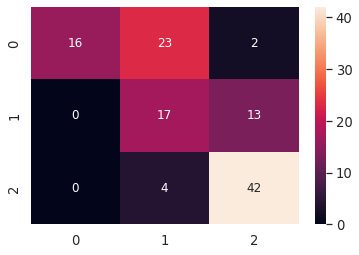

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[539.49  663.031 577.799 570.36  423.454 465.378 565.226 686.376 579.103
 458.39  709.809 326.243 292.293 505.974 375.969 492.813 369.128 670.368
 406.371 325.833 350.157 380.659 383.136 728.525 301.407 355.755 257.337
 663.83  527.279 714.458 512.791 430.489 289.357 542.251 253.988 650.853
 346.287 757.977 450.915 251.877 572.9   389.645 609.955 221.727 288.034
 354.155 841.964 303.581 430.805 235.497 368.448 245.817 500.426 265.528
 670.038 395.504 534.324 410.196 322.491 369.516 860.081 419.09  215.136
 439.712 651.134 347.257 267.205 787.158 285.953 417.271 355.107 509.454
 365.055 402.424 323.    223.904 596.573 629.193 261.314 468.052 321.81
 356.602 619.554 335.355 520.738 342.96  328.096 565.475 534.598 653.546
 406.052 328.75  617.373 336.804 285.761 334.055 492.336 332.222 541.392
 609.215 739.409 299.221 527.038 347.407 840.974 532.227 616.495 351.94
 376.065 319.118 314.496 518.78  4

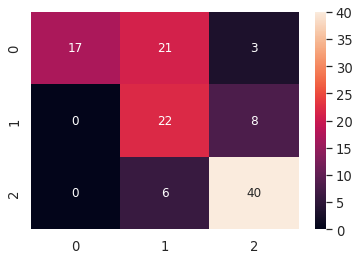

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 2/3] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=400;, score=-0.505 total time=   0.6s
[CV 1/3] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=5, n_estimators=1200;, score=-1.246 total time=   2.3s
[CV 1/3] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-1.253 total time=   1.5s
[CV 3/3] END bootstrap=True, max_depth=40, min_samples_leaf=1, min_samples_split=10, n_estimators=1600;, score=-0.118 total time=   3.2s
[CV 3/3] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=1000;, score=-0.111 total time=   1.9s
[CV 3/3] END bootstrap=True, max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.130 total time=   0.8s
[CV 2/3] END bootstrap=False, max_depth=80, min_samples_leaf=2, min_samples_split=10, n_e

[CV 1/3] END bootstrap=False, max_depth=80, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-1.572 total time=   0.7s[CV 1/3] END bootstrap=False, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=1600;, score=-2.475 total time=   3.7s
[CV 3/3] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1400;, score=-0.129 total time=   3.1s
[CV 1/3] END bootstrap=False, max_depth=90, min_samples_leaf=2, min_samples_split=5, n_estimators=1200;, score=-1.249 total time=   2.2s
[CV 1/3] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=1600;, score=-0.257 total time=   2.9s
[CV 1/3] END bootstrap=False, max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=600;, score=-2.484 total time=   1.1s
[CV 2/3] END bootstrap=False, max_depth=80, min_samples_leaf=1, min_samples_split=5, n_estimators=1400;, score=-0.527 total time=   3.1s
[CV 3/3] END bootstrap=True, max_depth=50

[CV 2/3] END bootstrap=False, max_depth=40, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=-0.505 total time=   0.3s
[CV 2/3] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=2000;, score=-0.524 total time=   4.5s
[CV 3/3] END bootstrap=False, max_depth=110, min_samples_leaf=2, min_samples_split=5, n_estimators=600;, score=-0.673 total time=   1.2s
[CV 3/3] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=400;, score=-0.878 total time=   0.7s
[CV 3/3] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=5, n_estimators=1200;, score=-0.671 total time=   2.3s
[CV 3/3] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-0.661 total time=   1.6s
[CV 2/3] END bootstrap=True, max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=2000;, score=0.033 total time=   3.8s
[CV 2/3] END bootstrap=False, max_depth=50,

[CV 1/3] END bootstrap=False, max_depth=50, min_samples_leaf=4, min_samples_split=2, n_estimators=2000;, score=-0.736 total time=   3.6s
[CV 1/3] END bootstrap=False, max_depth=60, min_samples_leaf=2, min_samples_split=10, n_estimators=1000;, score=-0.902 total time=   1.8s
[CV 2/3] END bootstrap=True, max_depth=60, min_samples_leaf=2, min_samples_split=2, n_estimators=1400;, score=0.009 total time=   2.9s
[CV 2/3] END bootstrap=False, max_depth=70, min_samples_leaf=4, min_samples_split=10, n_estimators=800;, score=-0.506 total time=   1.3s
[CV 1/3] END bootstrap=True, max_depth=70, min_samples_leaf=1, min_samples_split=2, n_estimators=1000;, score=-1.037 total time=   2.1s
[CV 3/3] END bootstrap=False, max_depth=100, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=-0.897 total time=   0.7s
[CV 2/3] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=0.028 total time=   1.9s
[CV 2/3] END bootstrap=True, max_depth=10, 

[CV 2/3] END bootstrap=True, max_depth=60, min_samples_leaf=2, min_samples_split=10, n_estimators=1800;, score=0.126 total time=   3.4s
[CV 1/3] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-0.801 total time=   1.5s
[CV 1/3] END bootstrap=True, max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=2000;, score=-0.467 total time=   3.8s
[CV 1/3] END bootstrap=False, max_depth=50, min_samples_leaf=4, min_samples_split=2, n_estimators=2000;, score=-1.152 total time=   3.4s
[CV 2/3] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=1800;, score=0.119 total time=   3.9s
[CV 2/3] END bootstrap=False, max_depth=90, min_samples_leaf=4, min_samples_split=2, n_estimators=1800;, score=-0.052 total time=   3.3s
[CV 2/3] END bootstrap=True, max_depth=90, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.068 total time=   0.4s
[CV 3/3] END bootstrap=False, max_depth=30, min

[533.259 549.509 613.462 652.61  479.515 351.602 522.257 646.623 516.89
 433.746 632.513 335.635 270.588 424.792 381.844 526.813 378.406 656.931
 332.467 315.696 348.69  452.792 437.718 699.588 305.017 306.42  249.283
 579.893 491.633 561.343 607.154 289.645 306.622 568.83  260.608 588.387
 461.07  797.897 404.966 260.904 599.744 463.222 628.892 346.382 298.805
 400.556 788.754 315.537 343.416 255.463 393.495 205.358 556.235 251.653
 475.091 398.905 556.34  307.86  290.859 303.612 839.777 373.673 228.629
 210.282 776.111 355.518 321.646 729.701 289.194 498.848 233.045 558.181
 483.58  478.514 382.052 413.217 563.028 608.769 288.965 593.017 367.131
 428.039 552.36  303.93  709.766 357.202 347.53  507.135 624.185 750.445
 418.605 313.521 694.055 272.852 266.36  403.348 646.992 482.421 588.944
 436.296 583.297 322.292 549.109 421.131 769.827 407.876 541.831 421.131
 386.162 408.567 325.256 461.268 488.67  271.935 582.217 502.508 311.14 ]
51916.26759160068 10320.212357560105 130567.0207181

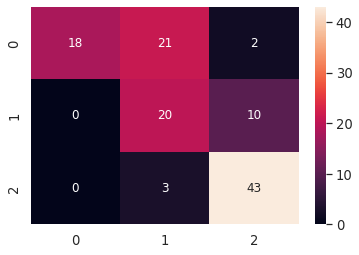

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 3/3] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=2000;, score=-0.984 total time=   4.2s
[CV 2/3] END bootstrap=False, max_depth=110, min_samples_leaf=2, min_samples_split=5, n_estimators=600;, score=-0.307 total time=   1.1s
[CV 1/3] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=400;, score=-0.741 total time=   0.7s
[CV 3/3] END bootstrap=False, max_depth=50, min_samples_leaf=1, min_samples_split=10, n_estimators=2000;, score=-0.957 total time=   3.7s
[CV 2/3] END bootstrap=True, max_depth=40, min_samples_leaf=1, min_samples_split=10, n_estimators=1600;, score=0.034 total time=   3.2s
[CV 2/3] END bootstrap=False, max_depth=60, min_samples_leaf=4, min_samples_split=10, n_estimators=1400;, score=-0.505 total time=   2.3s
[CV 1/3] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_

[ 304.831  515.681  449.186  693.513  485.188  348.861  512.913  870.694
  577.448  445.538  644.726  373.451  372.502  396.061  431.869  500.277
  284.966  511.337  430.02   399.311  378.111  333.246  421.378 1012.019
  204.548  286.003  206.213  620.123  570.087  442.303  547.123  302.817
  327.045  363.176  413.026  363.359  436.007 1227.846  317.945  172.494
  530.519  561.622  395.755  366.677  245.951  383.539 1297.682  246.623
  359.54   246.213  295.578  209.354  370.981  195.712  503.468  415.02
  481.521  431.469  342.564  257.43  1108.38   389.785  188.637  170.607
  906.128  312.952  226.399  889.722  205.986  529.919  249.072  512.32
  431.452  417.636  368.419  175.968  558.103  524.741  271.765  541.221
  411.072  363.861  524.104  335.907  600.321  443.009  383.983  445.344
  605.597 1062.158  444.137  243.545  634.967  218.716  263.602  345.866
  575.315  381.121  647.248  506.991  795.186  341.101  554.416  348.766
  987.304  343.833  882.945  406.327  315.931  301.22

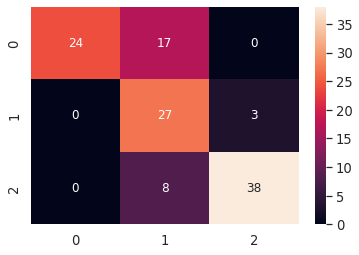

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 2/3] END bootstrap=False, max_depth=60, min_samples_leaf=4, min_samples_split=10, n_estimators=1400;, score=-0.112 total time=   2.4s
[CV 2/3] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=2000;, score=-0.004 total time=   4.2s
[CV 1/3] END bootstrap=False, max_depth=50, min_samples_leaf=4, min_samples_split=2, n_estimators=1400;, score=-1.428 total time=   2.3s
[CV 1/3] END bootstrap=True, max_depth=60, min_samples_leaf=4, min_samples_split=5, n_estimators=1600;, score=-0.428 total time=   3.0s
[CV 3/3] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=1600;, score=-0.054 total time=   3.0s
[CV 3/3] END bootstrap=True, max_depth=40, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.028 total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=80, min_samples_leaf=4, min_samples_split=2, n_est

[CV 2/3] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=800;, score=-0.622 total time=   1.7s
[CV 1/3] END bootstrap=False, max_depth=40, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-2.918 total time=   0.9s
[CV 1/3] END bootstrap=False, max_depth=90, min_samples_leaf=2, min_samples_split=10, n_estimators=1200;, score=-1.570 total time=   2.2s
[CV 1/3] END bootstrap=True, max_depth=40, min_samples_leaf=1, min_samples_split=5, n_estimators=2000;, score=-1.127 total time=   4.2s
[CV 2/3] END bootstrap=False, max_depth=110, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=-0.112 total time=   1.5s
[CV 3/3] END bootstrap=True, max_depth=80, min_samples_leaf=2, min_samples_split=2, n_estimators=1800;, score=-0.137 total time=   3.5s
[CV 2/3] END bootstrap=True, max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=1400;, score=-0.118 total time=   2.8s
[CV 3/3] END bootstrap=False, max_dept

[ 437.198  681.68   487.406  547.921  446.2    284.698  442.179  976.8
  493.443  530.126  486.703  411.933  251.772  356.863  402.597  487.729
  308.853  536.514  322.284  425.575  403.012  327.642  438.504  991.953
  253.871  304.896  350.575  608.571  609.49   520.25   443.99   330.161
  296.865  310.817  415.636  411.302  658.519  803.72   411.633  259.131
  556.367  702.447  568.447  410.895  289.104  413.797 1020.943  311.581
  411.384  240.765  283.716  363.969  368.961  257.383  403.766  379.465
  515.209  412.282  349.084  438.094  736.34   374.239  246.925  172.391
  667.673  380.876  280.875  872.895  334.946  407.465  265.275  496.828
  447.279  594.177  295.     270.48   572.392  499.669  213.692  411.421
  513.607  299.235  431.719  400.77   507.524  384.483  327.838  607.584
  512.339  595.194  463.994  371.389  585.407  390.419  407.777  404.058
  671.64   381.913  633.7    606.111  645.839  458.984  547.357  218.001
  684.667  350.503  521.791  447.773  492.307  278.28

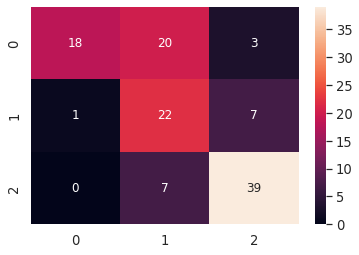

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits

[CV 3/3] END bootstrap=True, max_depth=60, min_samples_leaf=2, min_samples_split=5, n_estimators=1200;, score=0.032 total time=   2.4s
[CV 3/3] END bootstrap=False, max_depth=60, min_samples_leaf=4, min_samples_split=10, n_estimators=1400;, score=-0.123 total time=   2.7s
[CV 1/3] END bootstrap=False, max_depth=80, min_samples_leaf=2, min_samples_split=10, n_estimators=1200;, score=-1.567 total time=   2.2s
[CV 3/3] END bootstrap=False, max_depth=60, min_samples_leaf=2, min_samples_split=10, n_estimators=1000;, score=0.113 total time=   2.0s
[CV 3/3] END bootstrap=False, max_depth=50, min_samples_leaf=4, min_samples_split=2, n_estimators=1400;, score=-0.051 total time=   2.6s
[CV 3/3] END bootstrap=False, max_depth=70, min_samples_leaf=4, min_samples_split=10, n_estimators=800;, score=-0.122 total time=   1.5s
[CV 3/3] END bootstrap=True, max_depth=70, min_samples_leaf=1, min_samples_split=2, n

[CV 3/3] END bootstrap=True, max_depth=70, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=-0.023 total time=   0.4s
[CV 3/3] END bootstrap=True, max_depth=40, min_samples_leaf=1, min_samples_split=2, n_estimators=1200;, score=0.051 total time=   2.6s
[CV 2/3] END bootstrap=True, max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=1600;, score=-0.012 total time=   2.5s
[CV 2/3] END bootstrap=False, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-0.426 total time=   1.6s
[CV 3/3] END bootstrap=True, max_depth=90, min_samples_leaf=4, min_samples_split=2, n_estimators=1800;, score=-0.074 total time=   3.4s
[CV 2/3] END bootstrap=True, max_depth=80, min_samples_leaf=2, min_samples_split=5, n_estimators=1000;, score=-0.114 total time=   2.0s
[CV 3/3] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=-0.779 total time=   2.2s
[CV 3/3] END bootstrap=True, max_depth=10, min_


[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=-0.441 total time=   0.4s
[CV 1/3] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=1000;, score=-2.709 total time=   2.0s
[CV 3/3] END bootstrap=False, max_depth=90, min_samples_leaf=2, min_samples_split=10, n_estimators=1200;, score=0.117 total time=   2.6s
[CV 3/3] END bootstrap=False, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=1400;, score=-0.619 total time=   3.5s
[CV 2/3] END bootstrap=True, max_depth=80, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=0.033 total time=   0.4s
[CV 2/3] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=2000;, score=-0.407 total time=   4.6s
[CV 2/3] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=1600;, score=-0.187 total time=   2.9s
[CV 3/3] END bootstrap=True, max_depth

[CV 3/3] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.983 total time=   1.7s
[CV 1/3] END bootstrap=False, max_depth=80, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=-0.802 total time=   0.3s
[CV 1/3] END bootstrap=False, max_depth=70, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.613 total time=   1.0s
[CV 1/3] END bootstrap=False, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=1600;, score=-0.882 total time=   3.5s
[CV 1/3] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=1400;, score=-0.063 total time=   3.3s
[CV 2/3] END bootstrap=False, max_depth=70, min_samples_leaf=1, min_samples_split=10, n_estimators=400;, score=-0.485 total time=   0.8s
[CV 3/3] END bootstrap=True, max_depth=70, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=-0.089 total time=   0.7s
[CV 3/3] END bootstrap=False, max_depth=50,

[356.318 601.27  430.522 583.627 502.248 403.015 551.903 788.47  537.311
 456.973 620.726 292.555 209.591 600.981 432.007 494.868 317.463 527.236
 358.294 408.776 407.729 266.267 379.692 781.011 390.181 535.955 494.42
 647.005 523.431 499.877 461.269 302.728 375.578 461.467 265.816 441.967
 337.102 958.809 422.892 248.811 494.99  836.591 481.749 217.621 274.871
 284.901 878.404 298.651 508.697 236.984 311.637 298.018 465.597 267.649
 483.176 514.284 478.305 450.306 412.813 231.442 782.909 473.351 210.051
 274.511 662.894 303.479 445.967 916.056 334.596 744.659 258.991 483.894
 438.371 452.772 429.629 182.106 639.763 742.195 318.564 539.287 428.805
 402.364 547.137 309.523 601.7   405.112 405.025 329.938 555.388 748.37
 453.721 447.157 562.829 279.117 293.295 255.114 467.743 406.159 635.421
 540.742 776.182 265.916 521.504 318.761 512.617 255.898 712.712 452.592
 436.136 319.561 377.018 690.065 394.412 245.938 625.916 500.463 300.234]
50266.10059755018 12953.983881126176 120963.66187904

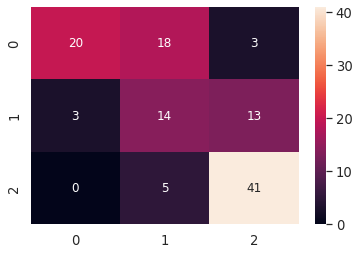

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[597.194 523.845 630.651 605.423 447.222 330.651 484.314 641.56  550.363
 462.66  637.252 358.752 255.567 369.387 372.433 547.846 403.199 670.546
 404.736 327.103 332.71  404.813 376.627 658.156 337.735 385.863 278.581
 601.881 543.569 624.642 521.882 446.059 270.525 610.128 293.792 628.804
 538.425 841.549 410.619 221.115 619.492 415.412 602.025 242.961 327.11
 357.744 829.763 341.103 331.009 255.432 388.918 247.522 511.802 293.345
 522.613 452.089 522.201 353.657 299.261 362.113 845.405 542.937 214.55
 217.887 703.742 377.09  319.451 750.659 344.708 480.928 298.232 478.17
 444.185 464.719 374.82  344.072 605.498 564.365 370.122 561.823 329.92
 418.309 481.892 288.388 638.023 371.404 324.741 438.88  511.144 717.706
 468.295 376.769 701.437 308.646 270.699 410.057 604.96  381.042 590.624
 454.281 623.422 312.972 526.176 454.281 777.372 451.553 553.89  454.447
 378.022 411.244 342.784 465.222 480

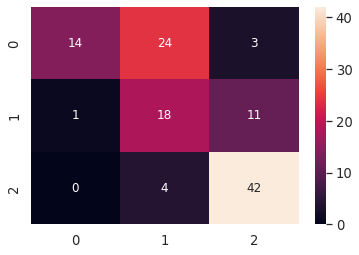

(117, 25)
(28, 25)
(117, 25)
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 2/3] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=-0.009 total time=   2.0s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=-0.005 total time=   0.5s
[CV 3/3] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=1000;, score=-2.549 total time=   2.2s
[CV 1/3] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=1800;, score=-1.105 total time=   3.3s
[CV 1/3] END bootstrap=False, max_depth=90, min_samples_leaf=2, min_samples_split=5, n_estimators=400;, score=-0.789 total time=   0.8s
[CV 3/3] END bootstrap=False, max_depth=90, min_samples_leaf=2, min_samples_split=5, n_estimators=400;, score=-0.558 total time=   0.8s
[CV 1/3] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=5, n_es

[CV 3/3] END bootstrap=False, max_depth=110, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=-1.507 total time=   1.1s
[CV 2/3] END bootstrap=True, max_depth=80, min_samples_leaf=2, min_samples_split=2, n_estimators=1800;, score=-0.131 total time=   4.1s
[CV 2/3] END bootstrap=True, max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=1400;, score=-0.143 total time=   3.2s
[CV 3/3] END bootstrap=False, max_depth=110, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=-0.464 total time=   0.9s
[CV 3/3] END bootstrap=True, max_depth=70, min_samples_leaf=1, min_samples_split=10, n_estimators=1600;, score=-0.064 total time=   3.4s
[CV 2/3] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=-0.179 total time=   0.4s
[CV 1/3] END bootstrap=False, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=1000;, score=-0.852 total time=   2.2s
[CV 1/3] END bootstrap=True, max_depth

[CV 3/3] END bootstrap=True, max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=1600;, score=-1.023 total time=   2.6s
[CV 3/3] END bootstrap=False, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=800;, score=-0.422 total time=   2.1s
[CV 1/3] END bootstrap=False, max_depth=80, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=-0.587 total time=   0.4s
[CV 1/3] END bootstrap=False, max_depth=70, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=-0.816 total time=   1.3s
[CV 1/3] END bootstrap=False, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=1600;, score=-1.140 total time=   4.2s
[CV 3/3] END bootstrap=False, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=-0.039 total time=   2.0s
[CV 1/3] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=2000;, score=0.051 total time=   4.5s
[CV 3/3] END bootstrap=False, max_depth=60

[CV 3/3] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=400;, score=-0.071 total time=   0.8s
[CV 3/3] END bootstrap=False, max_depth=80, min_samples_leaf=1, min_samples_split=5, n_estimators=1400;, score=-0.408 total time=   3.4s
[CV 2/3] END bootstrap=True, max_depth=50, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=-0.102 total time=   1.2s
[CV 2/3] END bootstrap=False, max_depth=50, min_samples_leaf=1, min_samples_split=10, n_estimators=2000;, score=-0.302 total time=   4.5s
[CV 3/3] END bootstrap=True, max_depth=40, min_samples_leaf=1, min_samples_split=10, n_estimators=1600;, score=-0.039 total time=   3.3s
[CV 3/3] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=1000;, score=-0.033 total time=   2.1s
[CV 3/3] END bootstrap=True, max_depth=50, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=-0.001 total time=   0.9s
[CV 1/3] END bootstrap=True, max_depth=110, mi

[CV 1/3] END bootstrap=True, max_depth=70, min_samples_leaf=4, min_samples_split=10, n_estimators=400;, score=0.081 total time=   0.8s
[CV 1/3] END bootstrap=False, max_depth=50, min_samples_leaf=1, min_samples_split=5, n_estimators=1200;, score=-0.929 total time=   2.7s
[CV 3/3] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=400;, score=0.000 total time=   0.8s
[CV 2/3] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=2000;, score=-0.382 total time=   4.8s
[CV 1/3] END bootstrap=False, max_depth=110, min_samples_leaf=2, min_samples_split=5, n_estimators=600;, score=-0.756 total time=   1.4s
[CV 1/3] END bootstrap=True, max_depth=60, min_samples_leaf=2, min_samples_split=10, n_estimators=1800;, score=0.064 total time=   3.8s
[CV 1/3] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-0.861 total time=   1.7s
[CV 1/3] END bootstrap=True, max_depth=110, min_

[CV 1/3] END bootstrap=False, max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=600;, score=-0.852 total time=   1.3s
[CV 2/3] END bootstrap=False, max_depth=80, min_samples_leaf=1, min_samples_split=5, n_estimators=1400;, score=-0.382 total time=   3.5s
[CV 3/3] END bootstrap=True, max_depth=50, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=-0.015 total time=   1.2s
[CV 1/3] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=5, n_estimators=1200;, score=-0.747 total time=   2.7s
[CV 1/3] END bootstrap=False, max_depth=100, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=-0.734 total time=   1.8s
[CV 2/3] END bootstrap=False, max_depth=80, min_samples_leaf=2, min_samples_split=10, n_estimators=400;, score=-0.181 total time=   0.8s
[CV 3/3] END bootstrap=False, max_depth=80, min_samples_leaf=2, min_samples_split=2, n_estimators=1000;, score=-0.449 total time=   2.1s
[CV 3/3] END bootstrap=True, max_depth=40

[CV 2/3] END bootstrap=False, max_depth=60, min_samples_leaf=2, min_samples_split=10, n_estimators=1400;, score=-0.178 total time=   3.0s
[CV 1/3] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=400;, score=0.039 total time=   0.9s
[CV 2/3] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=2, n_estimators=1000;, score=-0.144 total time=   2.6s
[CV 2/3] END bootstrap=False, max_depth=110, min_samples_leaf=2, min_samples_split=5, n_estimators=600;, score=-0.371 total time=   1.4s
[CV 3/3] END bootstrap=True, max_depth=60, min_samples_leaf=2, min_samples_split=10, n_estimators=1800;, score=-0.046 total time=   3.7s
[CV 2/3] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=2, n_estimators=800;, score=-0.377 total time=   1.7s
[CV 3/3] END bootstrap=True, max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=2000;, score=-0.049 total time=   4.1s
[CV 2/3] END bootstrap=False, max_depth=50,

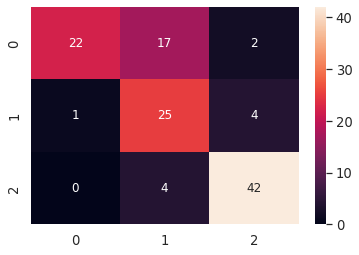

In [35]:
from sklearn.metrics import confusion_matrix

for Si in S:
    X_train_ = np.array(prune(x_train,Si))
    X_test_ = np.array(prune(x_test,Si))

    print(X_train_.shape)
    print(X_test_.shape)
    rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=3, random_state=42, n_jobs = -1)
    # Fit the random search model
    print(X_train_.shape)
    rf_random.fit(X_train_, y_train)
    rf_random.best_params_
    best_grid = rf_random.best_estimator_
    meanSE, medianSE, stdSE, spearmanR, y_pred = evaluate(best_grid, X_train_, y_train)
    print(meanSE, medianSE, stdSE, spearmanR)
    y_pred2=best_grid.predict(X_test_)
    print(y_pred2)
    for hh in y_pred2:
        print(hh)
    y_train_v, y_pred_v = classif(y_train,y_pred)
    cm = confusion_matrix(y_train_v, y_pred_v)

    sns.set(font_scale=1.2) 
    sns.heatmap(cm, annot=True, annot_kws={"size": 12}) 
    plt.show()


In [36]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV
# from sklearn.feature_selection import RFE
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import accuracy_score

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# print(random_grid)

In [37]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune


In [38]:
rf_random.best_params_


{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_depth': 10,
 'bootstrap': True}

In [39]:
# # Create the parameter grid based on the results of random search 
# param_grid = {
#     'min_samples_leaf': [2, 4, 6],
#     'min_samples_split': [2, 5, 6],
#     'max_depth': [30,20,10],
#     'n_estimators': [200, 300, 100],
#     'bootstrap': [True]
# }
# # Create a based model
# rf = RandomForestRegressor()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 4)
# grid_search.fit(X_train_, y_train)

In [40]:
# grid_search.best_params_


In [41]:
# # grid_search.best_params_
# # best_grid = grid_search.best_estimator_
# # meanSE, medianSE, stdSE, spearmanR, y_pred = evaluate(best_grid, X_test, y_test)
# # print(meanSE, medianSE, stdSE, spearmanR)

# grid_search.best_params_
# best_grid = grid_search.best_estimator_
# meanSE, medianSE, stdSE, spearmanR, y_pred = evaluate(best_grid, X_train_, y_train)
# print(meanSE, medianSE, stdSE, spearmanR)

In [42]:
y_pred2=best_grid.predict(X_test_)
print(y_pred2)
for hh in y_pred2:
    print(hh)

[425.796 459.104 426.661 402.098 456.769 428.661 391.695 424.514 452.563
 386.566 435.005 353.185 373.027 444.423 363.688 679.281 414.292 514.167
 434.044 418.47  571.096 342.366 339.17  449.421 456.02  433.187 426.89
 431.755]
425.7964701825952
459.10438326257093
426.66116065878555
402.0975818209569
456.7690361097238
428.6614832459209
391.6949204892329
424.51367945942934
452.56252364996146
386.56632997558023
435.0047797064046
353.18495212426456
373.02746946109437
444.4232531773783
363.6884887404261
679.281480977356
414.2923885281385
514.1665888555891
434.04403672716165
418.47024567099567
571.0963270479523
342.3655562007435
339.1695562007436
449.4210731490735
456.0202066267069
433.1867004939507
426.8898706709956
431.75514249639235


In [43]:
y_test_v = []
y_pred_v = []
for yi in y_train:
    if (yi < 300):
        y_test_v.append(0)
    elif (yi >= 300 and yi < 450):
        y_test_v.append(1)
    else:
        y_test_v.append(2)

for yi in y_pred:
    if (yi < 300):
        y_pred_v.append(0)
    elif (yi >= 300 and yi < 450):
        y_pred_v.append(1)
    else:
        y_pred_v.append(2)
        

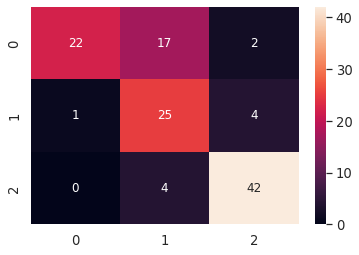

In [44]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test_v, y_pred_v)

sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, annot_kws={"size": 12}) 

plt.show()

In [45]:
from sklearn.metrics import classification_report

print(classification_report(y_test_v, y_pred_v))

              precision    recall  f1-score   support

           0       0.96      0.54      0.69        41
           1       0.54      0.83      0.66        30
           2       0.88      0.91      0.89        46

    accuracy                           0.76       117
   macro avg       0.79      0.76      0.75       117
weighted avg       0.82      0.76      0.76       117

[CV 2/3] END bootstrap=True, max_depth=40, min_samples_leaf=1, min_samples_split=5, n_estimators=2000;, score=0.017 total time=   4.3s
[CV 1/3] END bootstrap=False, max_depth=60, min_samples_leaf=2, min_samples_split=10, n_estimators=1400;, score=-0.708 total time=   2.7s
[CV 2/3] END bootstrap=False, max_depth=110, min_samples_leaf=1, min_samples_split=10, n_estimators=600;, score=-0.210 total time=   1.6s
[CV 3/3] END bootstrap=False, max_depth=80, min_samples_leaf=1, min_samples_split=5, n_estimators=1400;, score=-1.038 total time=   3.5s
[CV 1/3] END bootstrap=True, max_depth=60, min_samples_leaf=2, min_samp

[CV 2/3] END bootstrap=True, max_depth=40, min_samples_leaf=4, min_samples_split=10, n_estimators=1000;, score=0.021 total time=   1.9s
[CV 2/3] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.034 total time=   0.4s
[CV 2/3] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=1000;, score=-0.210 total time=   2.4s
[CV 3/3] END bootstrap=False, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=1800;, score=-1.738 total time=   3.5s
[CV 3/3] END bootstrap=False, max_depth=90, min_samples_leaf=2, min_samples_split=5, n_estimators=400;, score=-2.302 total time=   0.8s
[CV 2/3] END bootstrap=False, max_depth=80, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=-0.224 total time=   0.5s
[CV 2/3] END bootstrap=True, max_depth=30, min_samples_leaf=1, min_samples_split=5, n_estimators=1400;, score=0.017 total time=   2.7s
[CV 1/3] END bootstrap=True, max_depth=30, min